How does genre list length depend on gender?

Split the genre lists into two bins: those with length $\leq 5$ and those with length $\geq 6$. For each bin, calculate

$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$

where the expected number of male artists in a bin is ${(\% \text{male in total sample)} \cdot \text{(total in bin)}}$. Do the same for female artists. This gives a measure of bias. 

We find that for genre list lengths $\leq 5$, the ratio is close to $1$ for male and female artists. However, for list lengths $\geq 6$, male artists are over represented and female artists are under represented.


This is the script for calculating the bias and testing its statistical significance

In [4]:
import importlib.util
spec1 = importlib.util.spec_from_file_location("genre_data_loader", "/Users/Daniel/Code/Genre/project_code/analysis/genre_scripts/genre_data_loader.py")
spec2 = importlib.util.spec_from_file_location("genre_data_loader", "/Users/Daniel/Code/Genre/project_code/analysis/genre_scripts/nested_subsets.py")

genre_data_loader = importlib.util.module_from_spec(spec1)
nested_subsets = importlib.util.module_from_spec(spec2)


spec1.loader.exec_module(genre_data_loader)
spec2.loader.exec_module(nested_subsets)
#LoadGenreData = genre_data_loader.LoadGenreData
NestedSubsets = nested_subsets.NestedSubsets

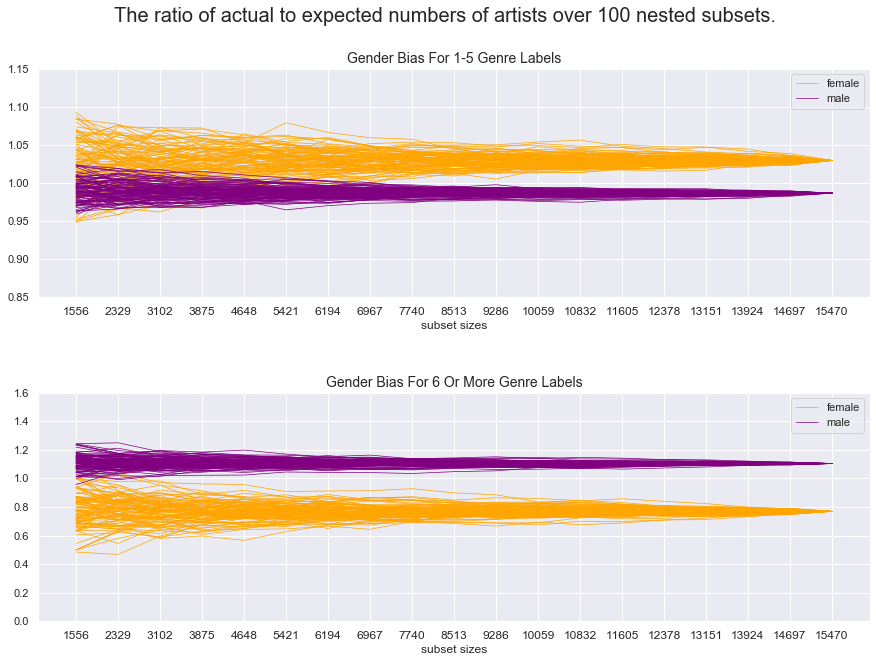

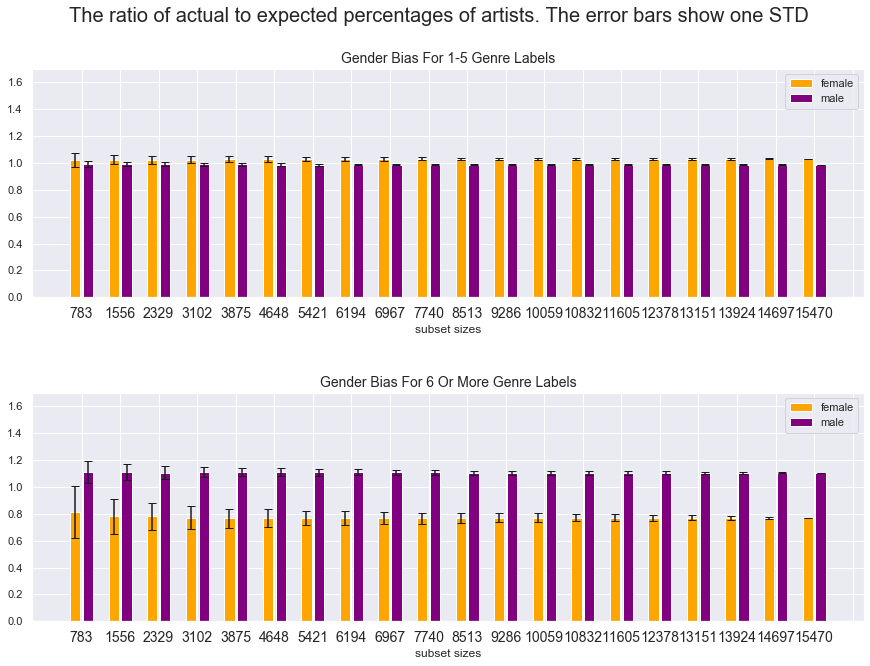

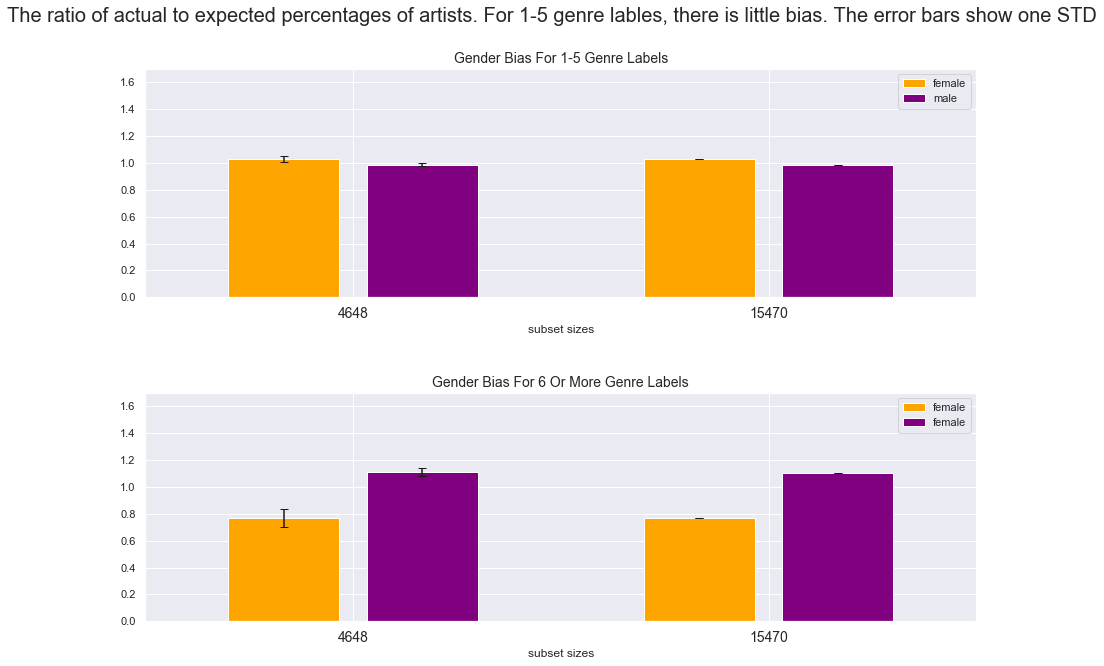

In [5]:
# import project_code.analysis.genre_scripts.genre_data_loader as genre_data_loader
# from project_code.analysis.genre_scripts.nested_subsets import NestedSubsets

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# get currrent date for latest version of data set
%store -r now

# import the data: train and test
X_path_train = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now)
y_path_train = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now)
X_path_test = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_test_{}.csv'.format(now)
y_path_test = '/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_test_{}.csv'.format(now)

# call data loader script
genre_data = genre_data_loader.LoadGenreData(now, X_path_train = X_path_train, y_path_train = y_path_train, 
                                             X_path_test = X_path_test, y_path_test = y_path_test)

# load data with genre sets
data = genre_data.as_sets()

# create list of all genres using the data loader
list_of_genres = genre_data.get_list_of_genres()

# Get percentages of male and female:
percent_fem = genre_data.get_percent_female()
percent_mal = genre_data.get_percent_male()

def main():
    
    # calculate frequency length counts by gender
    lcbg = create_length_counts_by_gender(data)
    
    # set the number of runs
    k = 100
    
    # set percentage for step size of subsets
    percentage = .05
    
    # calculate biases and mean and std over runs for each sequence of nested subset
    biases = bias_on_subsets(data, k = k, percentage = percentage)
    
    # generate figure with paths (path = biases for each nested subset)
    fig_paths = plot_bias_paths(biases, k)
    
    # save the figure
    fig_paths.savefig('/Users/Daniel/Code/Genre/visualizations/twobin_paths.png')
    
    # generate bar graph with mean and std over runs for each size  
    fig_means = plot_bias_stats(biases)
    
    # save the figure
    fig_means.savefig('/Users/Daniel/Code/Genre/visualizations/twobin_means.png')
    
    
    # generate bar graph with mean and std over runs for full set and size of 4648
    fig_means_select = plot_bias_stats_selection(biases)
    
    # save the figure
    fig_means_select.savefig('/Users/Daniel/Code/Genre/visualizations/twobin_means_selection.png')
    
    
# functions called

def create_length_counts_by_gender(df):
    """
    This function creates a DF with the frequencies of the lengths 
    of lists by gender for a df of the type of "data" output from genre_data_loader. 
    It is used in the bin_cv_est function below.
    
    Input: df = genre data for artists:
        columns: 'genrelist_length','gender'
        index: 'artist'
    
    Output: dataframe with counts by gender and total for each 
        length of genre list in the dataset
    
    Use: called by bin_bias to calculate gender bias in two bins,
    small (<6) and large (>5) genre list lengths
    """
    
    df = df.copy(deep = True)
    
    # length counts by gender
    df = df.groupby(['genrelist_length','gender']).count()
    df.columns = ['artist_count']

    df.reset_index(inplace = True)
    df.set_index(['genrelist_length'], inplace = True)
    df.index.name = 'genre list length'
    df = df.pivot(columns = 'gender')
    
    #flatten index and replace with single strings
    df.columns = df.columns.to_flat_index()
    df.columns = [f'{name[1]} '+f'{name[0]}'.replace("_"," ") for name in df.columns]
    df.fillna(value = 0, inplace = True)
    #create total count
    df['total'] = df[df.columns[0]]+df[df.columns[1]]
    df = df.astype('int32')
    
    return df

def bin_bias(df, percent_fem, percent_mal):
    """
    The bin_est function estimates actual/expected ratios 
    for male and female by genre list length by binning 
    the data into < 6 and > 5 bins.
    
    Input: 
        df = genre data for artists:
            columns: 'genrelist_length','gender'
            index: 'artist';
        percentage of female artists in dataset;
        percentage of male artists in dataset
    
    Output: dataframe with gender biases for two bins:
        small (<6) and large (>5) genre list lengths
        
    Use: used alone or in bias_est_ 
    """
    # create length counts by gender
    lcbg = create_length_counts_by_gender(df)

    # mark rows by their class (uses ordering; could be done with masking)
    lcbg['classify'] = '1-5'
    lcbg.loc[6:,'classify'] = '>5'
    # calculate totals for each bin
    twobins = lcbg.groupby(['classify']).agg('sum')
    
    # calculated columns: expected and ratios 
    twobins['expected female'] = (.31*twobins['total']).astype('int64')
    twobins['expected male'] = (.69*twobins['total']).astype('int64')
    twobins['male_act_exp_ratio'] =twobins['male artist count']/ twobins['expected male']
    twobins['female_act_exp_ratio'] =  twobins['female artist count']/ twobins['expected female']

    # only keep needed columns
    twobins = twobins[['female_act_exp_ratio','male_act_exp_ratio']]

    return twobins

def bias_on_subsets(data, k, step_size = None, percentage = .1):
    """Calculate the gender biases for the small (<6) 
    and large (>5) genre list lengths.
    Inputs:
        data = dataframe with genre data for artists:
            columns: 'genrelist_length','gender'
            index: 'artist';
        k = number of times nested subsets are created (number of runs)
        step_size = difference in sizes between subsets (except for remainder)
        percentage = percentage of full set to use to define step_size
        
    Output:
        dataframe with biases, mean, and std
    """

    # initialize a DataFrame to save biases calculated for each nested subsample
    # call NestedSubsets to get the_number_of_subsets and step_size
    subsets = NestedSubsets(data, step_size, percentage = percentage)
    number_of_steps = subsets.get_number_of_steps()
    step_size = subsets.get_step_size()

    # create list of sizes of subsets to use as level in MultiIndex
    sizes = [data.shape[0]-j*step_size for j in range(number_of_steps)]

    # create empty DF with MultiIndex
    indices = [sizes, ['1-5','>5']]
    columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
    biases = pd.DataFrame(index = pd.MultiIndex.from_product(indices), columns = pd.MultiIndex.from_product(columns), dtype = float)
    biases.index.names = ['size','bin']
    biases.columns.names = ['runs','gender']

    # define slicer for accessing slices of multi-indexed DF
    idx = pd.IndexSlice

    for i in range(k): # perform k runs
        # create the subset generator
        subsets = NestedSubsets(data, step_size, percentage = percentage)
        # get the step_size from the subset generator
        step_size = subsets.get_step_size()

        # loop through subsets
        for subset in subsets:
            size = subset.shape[0]
            if size >= step_size: # excluding the remainder samples
                twobins = bin_bias(subset, percent_fem, percent_mal) # calculate biases

                # set indices of twobins to match the slice of relevant biases 
                indices = [[size],['1-5', '>5']]
                columns = [[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]
                twobins.index = pd.MultiIndex.from_product(indices)
                twobins.columns = pd.MultiIndex.from_product(columns)

                # set values
                biases.loc[idx[[size],['1-5', '>5']],idx[[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]] = twobins

    biases.sort_index(ascending = False)
    means = biases.groupby(['gender'], axis = 1).mean()
    means.columns = pd.MultiIndex.from_product([['means'],['fem mean','mal mean']])
    stds = biases.groupby(['gender'], axis = 1).std()
    stds.columns = pd.MultiIndex.from_product([['stds'],['fem std','mal std']])
    biases = biases.join([means, stds])
    return biases


    
def plot_bias_paths(biases, k):    
    """plot the paths for the runs of each nested subsets"""
    fig, axs = plt.subplots(2,1, figsize = (14,10))
    fig.suptitle('The ratio of actual to expected numbers of artists over 100 nested subsets.', fontsize = 20)
    fig.tight_layout(pad = 6.0)

    idx = pd.IndexSlice
    # the data set
    df = biases
    df.sort_index(ascending = False) # needed for slicing

    # x-values for paths
    runs_index = np.flip(df.loc[idx[:,'1-5'],:].index.get_level_values(0).values)
    runs_index = runs_index[1:] # leave off the remainder subset

    # generate arrays in which each row is a run, from small subset to large
    fem_small_runs = np.stack([np.flip(df.loc[ idx[:,'1-5'], idx[[f'run_{i}'],['female_act_exp_ratio']] ].values.flatten()) for i in range(k)])
    mal_small_runs = np.stack([np.flip(df.loc[ idx[:,'1-5'], idx[[f'run_{i}'],['male_act_exp_ratio']] ].values.flatten()) for i in range(k)])
    fem_large_runs = np.stack([np.flip(df.loc[ idx[:,'>5'], idx[[f'run_{i}'],['female_act_exp_ratio']] ].values.flatten()) for i in range(k)])
    mal_large_runs = np.stack([np.flip(df.loc[ idx[:,'>5'], idx[[f'run_{i}'],['male_act_exp_ratio']] ].values.flatten()) for i in range(k)])

    # drop first value which is for the remainder set
    fem_small_runs = fem_small_runs[:,1:]
    mal_small_runs = mal_small_runs[:,1:]
    fem_large_runs = fem_large_runs[:,1:]
    mal_large_runs = mal_large_runs[:,1:]

    # plot paths
    for i in range(k):
        axs[0].plot(runs_index,fem_small_runs[i], color = 'orange', label = f'fem_small_runs_{i}', linewidth = .7 )

    for i in range(k):
        axs[0].plot(runs_index,mal_small_runs[i], color = 'purple', label = f'mal_small_runs_{i}', linewidth = .7 )

    for i in range(k):
        axs[1].plot(runs_index,fem_large_runs[i], color = 'orange', label = f'fem_large_runs_{i}', linewidth = .7 )

    for i in range(k):
        axs[1].plot(runs_index,mal_large_runs[i], color = 'purple', label = f'mal_large_runs_{i}', linewidth = .7 )

    # y range
    axs[0].set_ylim(bottom = .85, top = 1.15)
    axs[1].set_ylim(bottom = 0,top = 1.6)

    # set xticklabels; flip so order is small to large, as above
    xticklabels = runs_index
    xlabel_pos = runs_index # set the positions for labels

    # styling
    axs[0].set_xticks(xlabel_pos)
    axs[0].set_xticklabels(xticklabels, fontsize = 12, rotation = 0)
    axs[1].set_xticks(xlabel_pos)
    axs[1].set_xticklabels(xticklabels, fontsize = 12, rotation = 0)
    axs[0].set_title('Gender Bias for 1-5 genre labels'.title(), fontsize = 14)
    axs[1].set_title('Gender Bias for 6 or more genre labels'.title(), fontsize = 14)
    axs[0].set_xlabel('subset sizes', fontsize = 12)
    axs[1].set_xlabel('subset sizes', fontsize = 12)

    handles, labels = axs[0].get_legend_handles_labels()
    axs[0].legend(handles = [handles[0], handles[k]], labels = ['female', 'male'])
    handles, labels = axs[1].get_legend_handles_labels()
    axs[1].legend(handles = [handles[0], handles[k]], labels = ['female', 'male'])
    
    return fig

def plot_bias_stats(biases):
    idx = pd.IndexSlice
    df = biases
    # extract lists of values for the means of each category
    # flip arrays so that subset size increases left to right
    df_fem_small = np.flip(df.loc[ idx[:,'1-5'], idx[['means'],['fem mean']] ].values.flatten())
    df_fem_large = np.flip(df.loc[ idx[:,'>5'], idx[['means'],['fem mean']] ].values.flatten())
    df_mal_small = np.flip(df.loc[ idx[:,'1-5'], idx[['means'],['mal mean']] ].values.flatten())
    df_mal_large = np.flip(df.loc[ idx[:,'>5'], idx[['means'],['mal mean']] ].values.flatten())

    # extract the stds
    eb_fem_small = np.flip(df.loc[ idx[:,'1-5'], idx[['stds'],['fem std']] ].values.flatten())
    eb_fem_large = np.flip(df.loc[ idx[:,'>5'], idx[['stds'],['fem std']] ].values.flatten())
    eb_mal_small = np.flip(df.loc[ idx[:,'1-5'], idx[['stds'],['mal std']] ].values.flatten())
    eb_mal_large = np.flip(df.loc[ idx[:,'>5'], idx[['stds'],['mal std']] ].values.flatten())

    # indices for bars
    number_of_bars = len(df_fem_small)
    ind_fem = np.arange(0,3*number_of_bars,3)
    ind_mal = np.arange(1,3*number_of_bars+1,3)
    xlabel_pos = np.arange(0,3*number_of_bars+1,3)+.5

    # set xticklabels; flip so order is small to large, as above
    xticklabels = np.flip(df.loc[idx[:,'1-5'],:].index.get_level_values(0).values)

    fig, axs = plt.subplots(2,1, sharey = True, figsize = (14,10))
    fig.tight_layout(pad = 6.0)
    fig.suptitle('The ratio of actual to expected percentages of artists. The error bars show one STD', fontsize = 20)
    axs[0].bar(ind_fem,df_fem_small, color = 'orange', yerr = eb_fem_small, capsize = 4, label = 'female')
    axs[0].bar(ind_mal,df_mal_small, color = 'purple', yerr = eb_mal_small, capsize = 4, label = 'male')
    axs[1].bar(ind_fem,df_fem_large, color = 'orange', yerr = eb_fem_large, capsize = 4, label = 'female')
    axs[1].bar(ind_mal,df_mal_large, color = 'purple', yerr = eb_mal_large, capsize = 4, label = 'male')

    # y range
    axs[0].set_ylim(0,1.7)
    axs[1].set_ylim(0,1.7)

    # styles
    axs[0].set_title('Gender Bias for 1-5 genre labels'.title(), fontsize = 14)
    axs[1].set_title('Gender Bias for 6 or more genre labels'.title(), fontsize = 14)

    axs[0].set_xticks(xlabel_pos)
    axs[0].set_xticklabels(xticklabels, fontsize = 14, rotation = 0)
    axs[1].set_xticks(xlabel_pos)
    axs[1].set_xticklabels(xticklabels, fontsize = 14, rotation = 0)
    axs[0].set_xlabel('subset sizes', fontsize = 12)
    axs[1].set_xlabel('subset sizes', fontsize = 12)
    axs[0].legend()
    axs[1].legend()
    
    return fig

def plot_bias_stats_selection(biases):
    """This generates a bar graph of two subset sizes: full set and size of 4648.
    The significance of the latter is that it is the size at which the mean and std
    stabilize."""
    idx = pd.IndexSlice
    df = biases
    
    fem_small = biases.loc[[(4648,'1-5'),(15470,'1-5')], [('means','fem mean')]].values.flatten()
    eb_fem_small = biases.loc[[(4648,'1-5'),(15470,'1-5')], [('stds','fem std')]].values.flatten()
    fem_small_index = [1,4]
    mal_small = biases.loc[[(4648,'1-5'),(15470,'1-5')], [('means','mal mean')]].values.flatten()
    eb_mal_small = biases.loc[[(4648,'1-5'),(15470,'1-5')], [('stds','mal std')]].values.flatten()
    mal_small_index = [2,5]
    
    fem_large = biases.loc[[(4648,'>5'),(15470,'>5')], [('means','fem mean')]].values.flatten()
    eb_fem_large = biases.loc[[(4648,'>5'),(15470,'>5')], [('stds','fem std')]].values.flatten()
    fem_large_index = [1,4]
    mal_large = biases.loc[[(4648,'>5'),(15470,'>5')], [('means','mal mean')]].values.flatten()
    eb_mal_large = biases.loc[[(4648,'>5'),(15470,'>5')], [('stds','mal std')]].values.flatten()
    mal_large_index = [2,5]
    
    
    xlabel_pos = [1.5,4.5]

    
    # set xticklabels; flip so order is small to large, as above
    xticklabels = [4648, 15470]
      
    fig, axs = plt.subplots(2,1, sharey = True, figsize = (14,10))
    fig.tight_layout(pad = 6.0)
    fig.suptitle('The ratio of actual to expected percentages of artists. For 1-5 genre lables, there is little bias. The error bars show one STD', fontsize = 20)
    axs[0].bar(fem_small_index,fem_small, color = 'orange', yerr = eb_fem_small, capsize = 4, label = 'female')
    axs[0].bar(mal_small_index,mal_small, color = 'purple', yerr = eb_mal_small, capsize = 4, label = 'male')
    axs[1].bar(fem_large_index,fem_large, color = 'orange', yerr = eb_fem_large, capsize = 4, label = 'female')
    axs[1].bar(mal_large_index,mal_large, color = 'purple', yerr = eb_mal_large, capsize = 4, label = 'female')

    # x range
    axs[0].set_xlim(0,6)
    axs[1].set_xlim(0,6)

    # y range
    axs[0].set_ylim(0,1.7)
    axs[1].set_ylim(0,1.7)

    # styles
    axs[0].set_title('Gender Bias for 1-5 genre labels'.title(), fontsize = 14)
    axs[1].set_title('Gender Bias for 6 or more genre labels'.title(), fontsize = 14)

    axs[0].set_xticks(xlabel_pos)
    axs[0].set_xticklabels(xticklabels, fontsize = 14, rotation = 0)
    axs[1].set_xticks(xlabel_pos)
    axs[1].set_xticklabels(xticklabels, fontsize = 14, rotation = 0)
    axs[0].set_xlabel('subset sizes', fontsize = 12)
    axs[1].set_xlabel('subset sizes', fontsize = 12)
    axs[0].legend()
    axs[1].legend()
    
    return fig


main()

In [2]:
# tot = data.shape[0]
# mal = genre_data.get_number_of_male()
# fem = genre_data.get_number_of_female()
# print('{} total artists'.format(tot))
# print('There are {} unique genre labels.'.format(len(genrelist)))
# print('{} female artists, or {:0.0f}%'.format(fem, 100*percent_fem))
# print('{} male artists, or {:0.0f}%'.format(mal, 100*percent_mal))